# NLP with Disaster Tweets

https://www.kaggle.com/c/nlp-getting-started

In [2]:
import re
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from  sklearn.ensemble import VotingClassifier
from sklearn.svm import *
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

## Section 1: Read in data and EDA
### 1.1 Read in data

In [3]:
def clean_text(s):
    '''convert series of text to lowercase, remove punctuation and digits'''
    s = s.str.lower()
    s = s.str.replace('[^\w\s]','')
    s = s.str.replace('\d+', '')
    return s

#use train.csv for train/dev set, test.csv for test set
train = pd.read_csv(r'\Users\Narvi\Documents\MIDS_Berkeley\W207\final project\w207-group-project\train.csv')
test = pd.read_csv(r'\Users\Narvi\Documents\MIDS_Berkeley\W207\final project\w207-group-project\test.csv')

#clean up the text
train.text = clean_text(train.text)
test.text = clean_text(test.text)

# Randomizing the order of data
np.random.seed(42)
shuffle = np.random.permutation(np.arange(train['text'].shape[0]))
X,Y = train['text'][shuffle], train['target'][shuffle]

X_train,X_dev,y_train,y_dev = train_test_split(X, Y,test_size=0.2)
X_test = test.copy()

print('Training set count: {}'.format(len(X_train)))
print('Dev set count: {}'.format(len(X_dev)))
print('Test set count: {}\n'.format(len(X_test)))

print('head of original train dataset:')
train.head()

Training set count: 6090
Dev set count: 1523
Test set count: 3263

head of original train dataset:


,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,people receive wildfires evacuation orders in...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


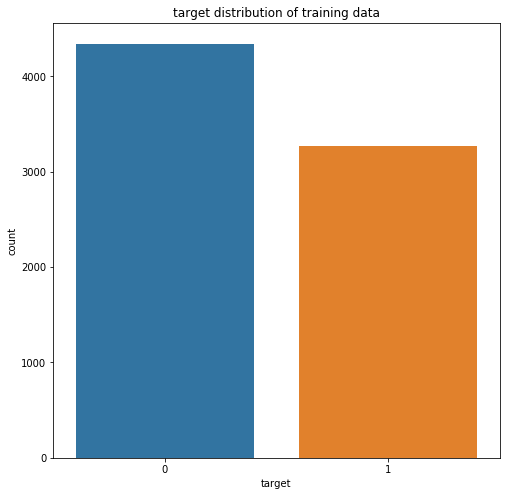

In [5]:
fig,ax = plt.subplots(figsize=(8,8))
_=sns.countplot(train.target)
_=ax.set_title('target distribution of training data')

## Section 2: Baseline model
### 2.1 Use Countvectorizer

In [90]:
vectorizer = CountVectorizer()
train_array = vectorizer.fit_transform(X_train)

In [91]:
train_array.shape

(6090, 18755)

In [92]:
vtest = vectorizer.transform(X_dev)
dev_array = vtest.toarray()
dev_array.shape

(1523, 18755)

In [93]:
#check values of one row
vectorizer.inverse_transform(train_array[0])

[array(['out', 'pass', 'may', 'quarantine', 'in', 'water', 'fill', 'and',
        'lot', 'dry', 'the', 'clean', 'to', 'have', 'am', 'since', 'eaten',
        'havent', 'still', 'update'], dtype='<U37')]

### 2.2 Fit Naive Bayes

In [94]:
nb = MultinomialNB().fit(train_array, y_train)

Text(0.5, 1.0, 'Confusion Matrix from training')

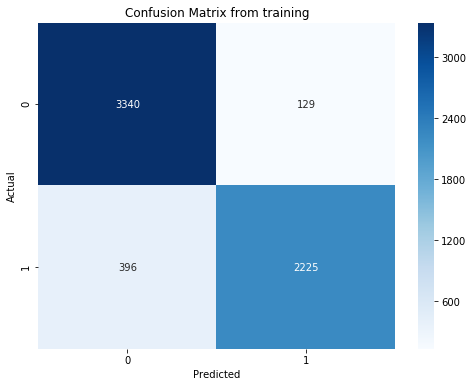

In [95]:
y_pred_train = nb.predict(train_array)
cf = confusion_matrix(y_train,y_pred_train)
fig,ax = plt.subplots(figsize=(8,6))
_=sns.heatmap(cf,annot=True,ax=ax,fmt='g',cmap='Blues')
_=ax.set_ylabel('Actual')
_=ax.set_xlabel('Predicted')
ax.set_title('Confusion Matrix from training')

In [96]:
print("training f1 score @ Naive Bayes:\n\n",metrics.accuracy_score(y_train,y_pred_train))

training f1 score @ Naive Bayes:

 0.9137931034482759


In [97]:
y_pred_dev = nb.predict(dev_array)

Text(0.5, 1.0, 'Confusion Matrix from training')

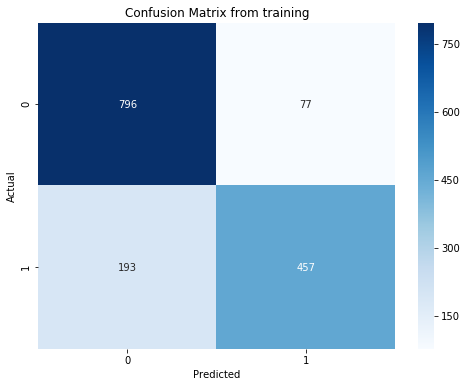

In [98]:
cf = confusion_matrix(y_dev,y_pred_dev)
fig,ax = plt.subplots(figsize=(8,6))
_=sns.heatmap(cf,annot=True,ax=ax,fmt='g',cmap='Blues')
_=ax.set_ylabel('Actual')
_=ax.set_xlabel('Predicted')
ax.set_title('Confusion Matrix from training')

In [99]:
print("DEV accuracy @ Naive Bayes:\n\n", metrics.accuracy_score(y_dev,y_pred_dev))

DEV accuracy @ Naive Bayes:

 0.8227183191070256


## Section 3: Alternate models using simple classification algorithms
### 3.1 Fit LogReg, SVM and Naivebayes models to the data, and optimize using grid search

Below we fit the 3 basic common machine learning models to the training data and optimize the regularization factor using grid search using the *fit_svm_lr_nb* custom function. The function below takes the training data and returns the svm, Logistic regression and naive bayes classification models with parameters optimized for the maximum accuracy.

In [100]:
#Creating a table to store all results in 
results_table = pd.DataFrame([metrics.accuracy_score(y_train,y_pred_train), metrics.accuracy_score(y_dev,y_pred_dev)]).T
results_table.index = ['Baseline']
results_table.columns = ['Training Set', 'Dev Set']

In [101]:
def fit_svm_lr_nb(train_array,y_train):
    
    train_array = train_array
    y_train = y_train
    
    #SVM
    svm = LinearSVC(loss='hinge', tol=0.005)
    param = {'C' : [0.05, 0.1, 0.2, 0.5, 1, 2]}
    grid_search = GridSearchCV(svm, param_grid=param, cv=5)
    grid_search.fit(train_array, y_train)
    print(grid_search.best_estimator_)
    svm = grid_search.best_estimator_
    svm.fit(train_array, y_train)  
    
    #LR
    lr = LogisticRegression(solver="liblinear", 
                            multi_class="auto",
                            tol=0.005)
    param = {'C' : [0.1, 0.5, 1, 10]}
    grid_search = GridSearchCV(lr, param_grid=param, cv=5)
    grid_search.fit(train_array, y_train) 
    print(grid_search.best_estimator_)
    lr = grid_search.best_estimator_
    lr.fit(train_array, y_train)  

    
    #NB
    nb = MultinomialNB()
    param = {'alpha' : [0.5, 1, 1.5, 2, 3, 10]}
    grid_search = GridSearchCV(nb, param_grid=param, cv=5)
    grid_search.fit(train_array, y_train)
    print(grid_search.best_estimator_)
    nb = grid_search.best_estimator_
    nb.fit(train_array, y_train)
    
    return(svm, lr, nb)

### 3.2 Using an ensemble of the Niave Bayes, SVM and Logistic Regression models with Vectorizer

Next we create an ensemble model using the 3 models that we created in the function above. The code below creates the ensemble model, and calculates tabulates the accuracy resulting from the 4 models that we have run so far.

In [102]:
def Ensemble_lr_nb_svm():
    
    print("Optimal parameters for the 3 classifiers listed below: \n")
    
    svm_clf, log_clf, multiNB = fit_svm_lr_nb(train_array, y_train)
    voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('svm', svm_clf), ('nb', multiNB)],
                                  voting = 'hard')
    
    voting_clf.fit(train_array, y_train)
    
    acc_scores_training = [metrics.accuracy_score(y_train,model.predict(train_array)) 
                          for model in [svm_clf, log_clf, multiNB, voting_clf]]

    acc_scores_dev = [metrics.accuracy_score(y_dev,model.predict(dev_array)) 
                          for model in [svm_clf, log_clf, multiNB, voting_clf]]
    
    scores = np.vstack((acc_scores_training, acc_scores_dev))
    scores = np.array(scores.T).reshape(4,-1)
    score_table = pd.DataFrame(scores)
    score_table.index = ['svm_clf_count_vect', 'log_clf_count_vect', 'multiNB_clf_count_vect', 'Ensemble_voting_clf_count_vect']
    score_table.columns = ['Training Set', 'Dev Set']
    return(score_table.round(3))
  
results_table = pd.concat([results_table, Ensemble_lr_nb_svm()])
print("\n")
pd.concat([results_table.head(1), results_table[-4:]]).round(3)

Optimal parameters for the 3 classifiers listed below: 

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.005, verbose=0)
LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.005, verbose=0, warm_start=False)
MultinomialNB(alpha=2, class_prior=None, fit_prior=True)




,Training Set,Dev Set
Baseline,0.914,0.823
svm_clf_count_vect,0.921,0.811
log_clf_count_vect,0.952,0.810
multiNB_clf_count_vect,0.894,0.819
Ensemble_voting_clf_count_vect,0.933,0.817


Note that none of these models give a big improvement over our baseline model.

### 3.3 Use TfidfVectorizer instead of the Countvectorizer

Next we use TfIdf Vectorizer instead of countvectorizer to vectorize the text. TfIdf Vectorizer is a more advanced algorithm for text vectorization over a simple coutvectorizer since it considers how common a word is in the overall training text in addition to the frequency in a given text and gives a higer weight to the the words with a higher semantic meaning.

In [103]:
vec_t = TfidfVectorizer()
X_train_vec = vec_t.fit_transform(X_train)  
X_dev_vec = vec_t.transform(X_dev)

### 3.4 Fit NaiveBayes and Logistic Reg Models on TfidfV

In [104]:
def Test_TfidV():
    
    print("Optimal parameters for the 3 classifiers listed below: \n")
    
    svm_clf, log_clf, multiNB = fit_svm_lr_nb(X_train_vec, y_train)
    voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('svm', svm_clf), ('nb', multiNB)],
                                  voting = 'hard')
    
    voting_clf.fit(X_train_vec, y_train)
    
    acc_scores_training = [metrics.accuracy_score(y_train,model.predict(train_array)) 
                          for model in [svm_clf, log_clf, multiNB, voting_clf]]

    acc_scores_dev = [metrics.accuracy_score(y_dev,model.predict(X_dev_vec)) 
                          for model in [svm_clf, log_clf, multiNB, voting_clf]]
    
    scores = np.vstack((acc_scores_training, acc_scores_dev))
    scores = np.array(scores.T).reshape(4,-1)
    score_table = pd.DataFrame(scores)
    score_table.index = ['svm_clf_TfIdf', 'log_clf_TfIdf', 'multiNB_clf_TfIdf', 'Ensemble_voting_clf_TfIdf']
    score_table.columns = ['Training Set', 'Dev Set']
    return(score_table)   
    
results_table = pd.concat([results_table, Test_TfidV()])
print("\n")
pd.concat([results_table.head(1), results_table[-4:]]).round(3)
    

Optimal parameters for the 3 classifiers listed below: 

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.005, verbose=0)
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.005, verbose=0, warm_start=False)
MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)




,Training Set,Dev Set
Baseline,0.914,0.823
svm_clf_TfIdf,0.916,0.813
log_clf_TfIdf,0.836,0.825
multiNB_clf_TfIdf,0.904,0.812
Ensemble_voting_clf_TfIdf,0.901,0.821


As expected, the TfIdf method provides a slightly better accuracy than the simple count vectorizer. Alternatively, we have below some pre-processing on the data to improve the the accuracy score. Stemming below is essentially reducing the words to their word stem.

### 3.5 Pre-process training data to improve model accuracy

In [105]:
def better_preprocessor(text, remove_vocab):

    """Accepts text and a remove_vocabulary list of words that need to removed from the text. Additionally 
    the function removes special characters and implements stemming on the text and returns the preprocessed text"""

    
    modified_text = text
    
    #Removing all the special characters !@#$%^&*() 
    # Decide to keep numbers and '?' since certain topics tend to have more numbers or questions in them. So
    # I did not want to simply remove these
    
    modified_text = re.sub(r'[!@#$%^&*()><?,.\"]', ' ' , modified_text)
    
    modified_text = re.sub(r'\n', ' ' , modified_text)
    
    #All lowercase to be able to use stop_words
    
    modified_text =  modified_text.lower()  
    
    # Removing the most commong words or stop words
    
    modified_text = " ".join([word for word in modified_text.split() if word not in remove_vocab])
    
    #Stemming: Stemming is the process of reducing inflected (or sometimes derived) words to their word stem, 
    #base or root form (from wikipedia). 
    
    from nltk.stem.porter import PorterStemmer
    stemmer = PorterStemmer()
    modified_text =  " ".join([stemmer.stem(word) for word in modified_text.split()])  
           
    return(modified_text)
    

### 3.6.1 Evaluate performance on pre-processed data with L2 regularization 

In [106]:
def test_better_processor():
    
    
    # Getting a list of the most common words that can be removed as features
    from collections import Counter
    cnt = Counter()
    for text in X_train:
        for word in text.lower().split():
            cnt[word] += 1

    common_words = cnt.most_common(25)
    #Checking the most common words, these are common words like I, am , and, etc that dont help train the model
    # Thus we remove these from the vocabulary
    
    remove_vocab = [w for (w, wc) in common_words]
    #print(remove_vocab)
    
    preprocessed_training_data = [better_preprocessor(i,remove_vocab) for i in X_train]
    preprocessed_dev_data = [better_preprocessor(i,remove_vocab) for i in X_dev]
    
    # vectorizer the count vectorizer
    preprocessed_training_array = vectorizer.fit_transform(preprocessed_training_data, y_train)
    preprocessed_dev_array = vectorizer.transform(preprocessed_dev_data)
    
    #fitting svm, lr, NB and ensemble 
    
    svm_clf, log_clf, multiNB = fit_svm_lr_nb(preprocessed_training_array, y_train)
    voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('svm', svm_clf), ('nb', multiNB)],
                                  voting = 'hard')
    
    voting_clf.fit(preprocessed_training_array, y_train)
    
    acc_scores_training = [metrics.accuracy_score(y_train,model.predict(preprocessed_training_array)) 
                          for model in [svm_clf, log_clf, multiNB, voting_clf]]

    acc_scores_dev = [metrics.accuracy_score(y_dev,model.predict(preprocessed_dev_array)) 
                          for model in [svm_clf, log_clf, multiNB, voting_clf]]
    
    scores = np.vstack((acc_scores_training, acc_scores_dev))
    scores = np.array(scores.T).reshape(4,-1)
    score_table = pd.DataFrame(scores)
    score_table.index = ['svm_clf_preprocessed', 'log_clf_preprocessed', 
                         'multiNB_clf_preprocessed', 'Ensemble_voting_clf_preprocessed']
    score_table.columns = ['Training Set', 'Dev Set']
    return(score_table)
    
results_table = pd.concat([results_table,test_better_processor()])

print("\n")
pd.concat([results_table.head(1), results_table[-4:]]).round(3)
    

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.005, verbose=0)
LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.005, verbose=0, warm_start=False)
MultinomialNB(alpha=1, class_prior=None, fit_prior=True)




,Training Set,Dev Set
Baseline,0.914,0.823
svm_clf_preprocessed,0.914,0.812
log_clf_preprocessed,0.943,0.816
multiNB_clf_preprocessed,0.910,0.826
Ensemble_voting_clf_preprocessed,0.933,0.818


### 3.6.2 Evaluate performance on pre-processed data with TfIdf with L2 regularization 

In [107]:
def test_better_processor_TfIdf():
    
    
    # Getting a list of the most common words that can be removed as features
    from collections import Counter
    cnt = Counter()
    for text in X_train:
        for word in text.lower().split():
            cnt[word] += 1

    common_words = cnt.most_common(25)
    #Checking the most common words, these are common words like I, am , and, etc that dont help train the model
    # Thus we remove these from the vocabulary
    
    remove_vocab = [w for (w, wc) in common_words]
    #print(remove_vocab)
    
    preprocessed_training_data = [better_preprocessor(i,remove_vocab) for i in X_train]
    preprocessed_dev_data = [better_preprocessor(i,remove_vocab) for i in X_dev]
    
    # vectorizer the count vectorizer
    preprocessed_training_array = vec_t.fit_transform(preprocessed_training_data, y_train)
    preprocessed_dev_array = vec_t.transform(preprocessed_dev_data)
    
    #fitting svm, lr, NB and ensemble 
    
    svm_clf, log_clf, multiNB = fit_svm_lr_nb(preprocessed_training_array, y_train)
    voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('svm', svm_clf), ('nb', multiNB)],
                                  voting = 'hard')
    
    voting_clf.fit(preprocessed_training_array, y_train)
    
    acc_scores_training = [metrics.accuracy_score(y_train,model.predict(preprocessed_training_array)) 
                          for model in [svm_clf, log_clf, multiNB, voting_clf]]

    acc_scores_dev = [metrics.accuracy_score(y_dev,model.predict(preprocessed_dev_array)) 
                          for model in [svm_clf, log_clf, multiNB, voting_clf]]
    
    scores = np.vstack((acc_scores_training, acc_scores_dev))
    scores = np.array(scores.T).reshape(4,-1)
    score_table = pd.DataFrame(scores)
    score_table.index = ['svm_clf_preprocessed_TfIdf', 'log_clf_preprocessed_TfIdf', 
                         'multiNB_clf_preprocessed_TfIdf', 'Ensemble_voting_clf_preprocessed_TfIdf']
    score_table.columns = ['Training Set', 'Dev Set']
    return(score_table)
    
results_table = pd.concat([results_table,test_better_processor_TfIdf()])

print("\n")
pd.concat([results_table.head(1), results_table[-8:]]).round(3)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.005, verbose=0)
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.005, verbose=0, warm_start=False)
MultinomialNB(alpha=1, class_prior=None, fit_prior=True)




,Training Set,Dev Set
Baseline,0.914,0.823
svm_clf_preprocessed,0.914,0.812
log_clf_preprocessed,0.943,0.816
multiNB_clf_preprocessed,0.910,0.826
Ensemble_voting_clf_preprocessed,0.933,0.818
svm_clf_preprocessed_TfIdf,0.932,0.816
log_clf_preprocessed_TfIdf,0.889,0.820
multiNB_clf_preprocessed_TfIdf,0.891,0.803
Ensemble_voting_clf_preprocessed_TfIdf,0.906,0.820


It can be seen above that the use of preprocessing and TfIdf yield similar results and none of the results are a definate improvement over our baseline model. Below we try out L1 regularization to reduce the number of non-zero weights for features. The results below show that L2 regularization results better results in comparison with L1 results for this NLP problem.

### 3.7 Evaluate performance on pre-processed data with L1 regularization to select only the important features

In [108]:
def fit_svm_lr_nb_L1(train_array,y_train):
    
    train_array = train_array
    y_train = y_train

    
    #LR
    lr = LogisticRegression(penalty='l1',
                            solver="saga", 
                            multi_class="auto",
                            tol=0.005)
    param = {'C' : [1, 10, 100, 500]}
    grid_search = GridSearchCV(lr, param_grid=param, cv=5)
    grid_search.fit(train_array, y_train) 
    print(grid_search.best_estimator_)
    lr = grid_search.best_estimator_
    lr.fit(train_array, y_train)  

    
    #NB
    nb = MultinomialNB()
    param = {'alpha' : [1, 1.5, 2, 3, 10]}
    grid_search = GridSearchCV(nb, param_grid=param, cv=5)
    grid_search.fit(train_array, y_train)
    print(grid_search.best_estimator_)
    nb = grid_search.best_estimator_
    nb.fit(train_array, y_train)
    
    
    #Ensemble
    voting_clf = VotingClassifier(estimators=[('lr', lr), ('nb', nb)],
                                  voting = 'soft')
    
    voting_clf.fit(train_array, y_train)
    
    
    #All f1 scores
    f1_scores_training = [metrics.f1_score(y_train,model.predict(train_array)) 
                          for model in [lr, nb, voting_clf]]

    f1_scores_dev = [metrics.f1_score(y_dev,model.predict(dev_array)) 
                          for model in [lr, nb, voting_clf]]
    
    f1_scores = np.vstack((f1_scores_training, f1_scores_dev))
    f1_scores = np.array(f1_scores.T).reshape(3,-1)
    score_table = pd.DataFrame(f1_scores)
    score_table.index = ['log_clf', 'multiNB_clf', 'Ensemble_voting_clf']
    score_table.columns = ['Training Set', 'Dev Set']
    return(score_table.round(3))
    
fit_svm_lr_nb_L1(train_array,y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l1', random_state=None, solver='saga',
          tol=0.005, verbose=0, warm_start=False)
MultinomialNB(alpha=2, class_prior=None, fit_prior=True)


,Training Set,Dev Set
log_clf,0.938,0.760
multiNB_clf,0.868,0.762
Ensemble_voting_clf,0.888,0.779


Before we proceed to the neural network models, below is a tabulation of the results from the simple machine learning techniques that we tried out.

In [118]:
results_table.sort_values(by='Dev Set', ascending=False).round(3)

,Training Set,Dev Set
multiNB_clf_preprocessed,0.910,0.826
log_clf_TfIdf,0.836,0.825
Baseline,0.914,0.823
Ensemble_voting_clf_TfIdf,0.901,0.821
log_clf_preprocessed_TfIdf,0.889,0.820
Ensemble_voting_clf_preprocessed_TfIdf,0.906,0.820
multiNB_clf_count_vect,0.894,0.819
Ensemble_voting_clf_preprocessed,0.933,0.818
Ensemble_voting_clf_count_vect,0.933,0.817
log_clf_preprocessed,0.943,0.816


### Section 4: Neural Networks

#### 4.1 Implementing a simple Deep Neural Network using Keras/Tensorflow

Below we implement a simple neural network model using *Sequential API* in Tensorflow. We use 2 layers of 250 neurons each to start with. Further down, we will optimize the number of layers and neurons to maximize the accuracy score.

In [109]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(keras.__version__)

1.13.1
2.2.4-tf


In [110]:
n_nuerons = 250

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape = train_array.shape[1:]),
    keras.layers.Dense(n_nuerons, activation='relu'),
    keras.layers.Dense(n_nuerons, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid') #Binary classification and hence sigmoid
])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 250)               4689000   
_________________________________________________________________
dense_1 (Dense)              (None, 250)               62750     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 251       
Total params: 4,752,001
Trainable params: 4,752,001
Non-trainable params: 0
_________________________________________________________________


In [36]:
#compiling the model
model.compile(loss='binary_crossentropy',
             optimizer=keras.optimizers.SGD(lr=0.01),
             metrics=["accuracy"])

#fitting the model

history = model.fit(train_array,y_train, epochs=25,
                    validation_data=(dev_array, y_dev))

Train on 6090 samples, validate on 1523 samples
Epoch 1/25
6090/6090 [==============================] - 5s 816us/sample - loss: 0.6865 - acc: 0.5665 - val_loss: 0.6804 - val_acc: 0.5732
Epoch 2/25
6090/6090 [==============================] - 5s 750us/sample - loss: 0.6787 - acc: 0.5696 - val_loss: 0.6744 - val_acc: 0.5732
Epoch 3/25
6090/6090 [==============================] - 5s 750us/sample - loss: 0.6730 - acc: 0.5698 - val_loss: 0.6676 - val_acc: 0.5732
Epoch 4/25
6090/6090 [==============================] - 5s 761us/sample - loss: 0.6657 - acc: 0.5709 - val_loss: 0.6587 - val_acc: 0.5791
Epoch 5/25
6090/6090 [==============================] - 5s 768us/sample - loss: 0.6560 - acc: 0.5897 - val_loss: 0.6469 - val_acc: 0.6165
Epoch 6/25
6090/6090 [==============================] - 5s 782us/sample - loss: 0.6434 - acc: 0.6366 - val_loss: 0.6320 - val_acc: 0.6691
Epoch 7/25
6090/6090 [==============================] - 5s 822us/sample - loss: 0.6277 - acc: 0.6716 - val_loss: 0.6148 - va

Below is a plot of the learning curves as a function of the number of epochs. Notice that the validation set accuracy maximizes to 81% close to the 20th epoch and flattens out thereafter. Beyond that point, the accuracy of the training set continues to increase and therefore the model continues to overfit to the test data. The number of epochs should therefore be limited to 20.

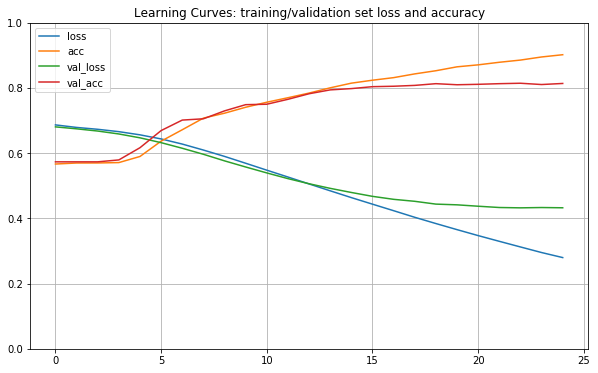

In [49]:
pd.DataFrame(history.history).plot(figsize=(10,6))
plt.grid(True)
plt.title("Learning Curves: training/validation set loss and accuracy")
plt.gca().set_ylim(0,1)
plt.show()

#### 4.2 Implementing a 'Wide & Deep' NN model

Besides keeping the deep network, we connect the input directly to the output so that network can learn both deep patterns and simple rules. We implement this network using the **Functional API** in Tensorflow

In [125]:
n_neurons = 200

input_reg = keras.layers.Input(shape=train_array.shape[1:], name='input')
hidden1 = keras.layers.Dense(n_neurons, activation='relu',  name='hidden1')(input_reg)
hidden2 = keras.layers.Dense(n_neurons, activation='relu', name='hidden2')(hidden1)
concat = keras.layers.concatenate([hidden2, input_reg], name='concat') # adding a wide path 
output_reg = keras.layers.Dense(1, activation='sigmoid', name='output')(concat)

model_reg = keras.Model(inputs=input_reg, outputs=output_reg)

model_reg.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 18755)        0                                            
__________________________________________________________________________________________________
hidden1 (Dense)                 (None, 200)          3751200     input[0][0]                      
__________________________________________________________________________________________________
hidden2 (Dense)                 (None, 200)          40200       hidden1[0][0]                    
__________________________________________________________________________________________________
concat (Concatenate)            (None, 18955)        0           hidden2[0][0]                    
                                                                 input[0][0]                      
__________

In [126]:
model_reg.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.SGD(lr=0.01), 
                  metrics=["accuracy"])

history_reg = model_reg.fit(train_array, y_train, epochs=35,
                            validation_data=(dev_array, y_dev))


Train on 6090 samples, validate on 1523 samples
Epoch 1/35
6090/6090 [==============================] - 23s 4ms/sample - loss: 0.6828 - acc: 0.5883 - val_loss: 0.6707 - val_acc: 0.5975
Epoch 2/35
6090/6090 [==============================] - 9s 1ms/sample - loss: 0.6669 - acc: 0.6023 - val_loss: 0.6570 - val_acc: 0.6205
Epoch 3/35
6090/6090 [==============================] - 10s 2ms/sample - loss: 0.6555 - acc: 0.6291 - val_loss: 0.6462 - val_acc: 0.6540
Epoch 4/35
6090/6090 [==============================] - 9s 2ms/sample - loss: 0.6458 - acc: 0.6550 - val_loss: 0.6369 - val_acc: 0.6743 - loss: 0.6464 - acc: - ETA: 2s
Epoch 5/35
6090/6090 [==============================] - 9s 2ms/sample - loss: 0.6374 - acc: 0.6711 - val_loss: 0.6289 - val_acc: 0.6848
Epoch 6/35
6090/6090 [==============================] - 9s 2ms/sample - loss: 0.6299 - acc: 0.6833 - val_loss: 0.6218 - val_acc: 0.6940
Epoch 7/35
6090/6090 [==============================] - 9s 2ms/sample - loss: 0.6231 - acc: 0.6913 - v

#### 4.3 Optimization of Neural Network model

Next we create a KerasClassifier object which is a wrapper around the Keras model to enable us to used grid search. We use Randomized search since we have too many vaiables that can be modified to optimize the model. To avoid a extremely long training times,we have used RandomizedSearchCV. 

* As a first step, we iterate for up to 3 hidden layers and various values forthe neural network
* Once we are able to narrow down the parameters, we run another RandomizedSeachCV instance to further fine tune the parameters.

In [67]:
def build_model(n_layers = 2, n_neurons=200, learning_rate=0.01):
     
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape = train_array.shape[1:]))
    for i in range(n_layers):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid')) #Binary classification and hence sigmoid

    model.compile(loss='binary_crossentropy',
                 optimizer=keras.optimizers.SGD(lr=learning_rate),
                 metrics=["accuracy"])
    
    return model

In [91]:
keras_clr = keras.wrappers.scikit_learn.KerasClassifier(build_model)

params = {
    'n_layers' : [1,2,3],
    'n_neurons' : range(200,501,20),
    'learning_rate' : [0.01]
}

random_search_cv = RandomizedSearchCV(keras_clr, n_iter=10, param_distributions=params, cv=3)
random_search_cv.fit(train_array, y_train, 
                   epochs=100, # putting a high number since we will implement early stopping 
                   validation_data=(dev_array, y_dev),
                   callbacks = [keras.callbacks.EarlyStopping(patience=5,
                                                              restore_best_weights=True)])

Train on 4060 samples, validate on 1523 samples
Epoch 1/100
4060/4060 [==============================] - 18s 5ms/sample - loss: 0.6893 - acc: 0.5542 - val_loss: 0.6842 - val_acc: 0.5732
Epoch 2/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.6824 - acc: 0.5670 - val_loss: 0.6790 - val_acc: 0.5732
Epoch 3/100
4060/4060 [==============================] - 9s 2ms/sample - loss: 0.6780 - acc: 0.5670 - val_loss: 0.6751 - val_acc: 0.5732 ETA: 0s - loss: 0.6777 - acc: 0.5
Epoch 4/100
4060/4060 [==============================] - 9s 2ms/sample - loss: 0.6739 - acc: 0.5670 - val_loss: 0.6709 - val_acc: 0.57320.6740 -  - ETA: 4s  - ETA: 0s - loss: 0.67
Epoch 5/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.6692 - acc: 0.5672 - val_loss: 0.6660 - val_acc: 0.5739
Epoch 6/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.6636 - acc: 0.5695 - val_loss: 0.6602 - val_acc: 0.5798
Epoch 7/100
4060/4060 [=============================

4060/4060 [==============================] - 9s 2ms/sample - loss: 0.2624 - acc: 0.9177 - val_loss: 0.4428 - val_acc: 0.8043
Epoch 34/100
4060/4060 [==============================] - 9s 2ms/sample - loss: 0.2475 - acc: 0.9271 - val_loss: 0.4463 - val_acc: 0.8004loss: 0.2417 - acc: 0.9 - ETA: 2s - loss: 0. - ETA: 1s - loss: 0.2438 - acc: 0. - ETA: 0s - loss: 0.245
Epoch 35/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2330 - acc: 0.9342 - val_loss: 0.4443 - val_acc: 0.80435s - loss: 0.2304
Epoch 36/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2192 - acc: 0.9379 - val_loss: 0.4473 - val_acc: 0.8017ETA: 3s - loss: 0.2188 - acc: - ETA: 3s - loss: 0.2221 - acc: 0.9 - ETA: 2s - loss: 0.2232 - acc: 0.9 - ETA: 2s - loss: 0.2229 - a
Epoch 37/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2068 - acc: 0.9468 - val_loss: 0.4494 - val_acc: 0.8024
Epoch 38/100
4060/4060 [==============================] - 4s 1ms/sample -

4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3090 - acc: 0.9012 - val_loss: 0.4575 - val_acc: 0.7932
Epoch 52/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3038 - acc: 0.9010 - val_loss: 0.4572 - val_acc: 0.7978
Epoch 53/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2989 - acc: 0.9037 - val_loss: 0.4564 - val_acc: 0.7951
Epoch 54/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2939 - acc: 0.9062 - val_loss: 0.4560 - val_acc: 0.7958
Epoch 55/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2892 - acc: 0.9086 - val_loss: 0.4561 - val_acc: 0.7984
Epoch 56/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2846 - acc: 0.9111 - val_loss: 0.4556 - val_acc: 0.8011
Epoch 57/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2798 - acc: 0.9131 - val_loss: 0.4553 - val_acc: 0.8017
Epoch 58/100
4060/4060 [=======================

Epoch 43/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3732 - acc: 0.8675 - val_loss: 0.4592 - val_acc: 0.8076
Epoch 44/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3677 - acc: 0.8682 - val_loss: 0.4574 - val_acc: 0.8083
Epoch 45/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3621 - acc: 0.8714 - val_loss: 0.4558 - val_acc: 0.8096
Epoch 46/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3565 - acc: 0.8751 - val_loss: 0.4544 - val_acc: 0.8083
Epoch 47/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3512 - acc: 0.8764 - val_loss: 0.4531 - val_acc: 0.8089
Epoch 48/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3459 - acc: 0.8810 - val_loss: 0.4515 - val_acc: 0.8089
Epoch 49/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3406 - acc: 0.8840 - val_loss: 0.4499 - val_acc: 0.8135
Epoch 50/100
4060/4060 [==========

Epoch 26/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.4887 - acc: 0.8032 - val_loss: 0.5129 - val_acc: 0.7682
Epoch 27/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.4814 - acc: 0.8089 - val_loss: 0.5087 - val_acc: 0.7715
Epoch 28/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.4743 - acc: 0.8116 - val_loss: 0.5043 - val_acc: 0.7708
Epoch 29/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.4671 - acc: 0.8160 - val_loss: 0.5004 - val_acc: 0.7748
Epoch 30/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.4601 - acc: 0.8212 - val_loss: 0.4967 - val_acc: 0.7807
Epoch 31/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.4531 - acc: 0.8256 - val_loss: 0.4929 - val_acc: 0.7807
Epoch 32/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.4460 - acc: 0.8315 - val_loss: 0.4894 - val_acc: 0.7827
Epoch 33/100
4060/4060 [==========

4060/4060 [==============================] - 9s 2ms/sample - loss: 0.2740 - acc: 0.9133 - val_loss: 0.4487 - val_acc: 0.81163s - loss: 0.2886 - acc:  - ETA: 3s - loss: 0.2856  - ETA:  - ETA: 0s - loss: 0.2781 - acc
Epoch 26/100
4060/4060 [==============================] - 9s 2ms/sample - loss: 0.2447 - acc: 0.9246 - val_loss: 0.4467 - val_acc: 0.8050
Epoch 27/100
4060/4060 [==============================] - 9s 2ms/sample - loss: 0.2172 - acc: 0.9367 - val_loss: 0.4613 - val_acc: 0.7919A:
Epoch 28/100
4060/4060 [==============================] - 9s 2ms/sample - loss: 0.1910 - acc: 0.9478 - val_loss: 0.4576 - val_acc: 0.8024
Epoch 29/100
4060/4060 [==============================] - 9s 2ms/sample - loss: 0.1672 - acc: 0.9574 - val_loss: 0.4628 - val_acc: 0.7978- l - ETA: 1s - lo
Epoch 30/100
4060/4060 [==============================] - 9s 2ms/sample - loss: 0.1456 - acc: 0.9667 - val_loss: 0.4713 - val_acc: 0.8056
Epoch 31/100
4060/4060 [==============================] - 4s 1ms/sample - l

4060/4060 [==============================] - 4s 910us/sample - loss: 0.2659 - acc: 0.9227s - loss: 0.2664 - acc: 0.922
Train on 4060 samples, validate on 1523 samples
Epoch 1/100
4060/4060 [==============================] - 17s 4ms/sample - loss: 0.6864 - acc: 0.5682 - val_loss: 0.6800 - val_acc: 0.5765
Epoch 2/100
4060/4060 [==============================] - 6s 1ms/sample - loss: 0.6758 - acc: 0.5724 - val_loss: 0.6711 - val_acc: 0.5758
Epoch 3/100
4060/4060 [==============================] - 6s 2ms/sample - loss: 0.6677 - acc: 0.5739 - val_loss: 0.6634 - val_acc: 0.5811
Epoch 4/100
4060/4060 [==============================] - 6s 2ms/sample - loss: 0.6600 - acc: 0.5857 - val_loss: 0.6556 - val_acc: 0.5929
Epoch 5/100
4060/4060 [==============================] - 6s 2ms/sample - loss: 0.6520 - acc: 0.6022 - val_loss: 0.6476 - val_acc: 0.6179
Epoch 6/100
4060/4060 [==============================] - 6s 2ms/sample - loss: 0.6436 - acc: 0.6308 - val_loss: 0.6391 - val_acc: 0.6467
Epoch 7/10

Epoch 40/100
4060/4060 [==============================] - 6s 2ms/sample - loss: 0.3899 - acc: 0.8623 - val_loss: 0.4636 - val_acc: 0.7932
Epoch 41/100
4060/4060 [==============================] - 6s 2ms/sample - loss: 0.3837 - acc: 0.8643 - val_loss: 0.4615 - val_acc: 0.7971
Epoch 42/100
4060/4060 [==============================] - 6s 2ms/sample - loss: 0.3777 - acc: 0.8670 - val_loss: 0.4595 - val_acc: 0.7951
Epoch 43/100
4060/4060 [==============================] - 6s 2ms/sample - loss: 0.3718 - acc: 0.8712 - val_loss: 0.4578 - val_acc: 0.7958
Epoch 44/100
4060/4060 [==============================] - 6s 2ms/sample - loss: 0.3658 - acc: 0.8709 - val_loss: 0.4561 - val_acc: 0.8050
Epoch 45/100
4060/4060 [==============================] - 6s 2ms/sample - loss: 0.3600 - acc: 0.8751 - val_loss: 0.4543 - val_acc: 0.7997
Epoch 46/100
4060/4060 [==============================] - 6s 2ms/sample - loss: 0.3544 - acc: 0.8793 - val_loss: 0.4529 - val_acc: 0.8004
Epoch 47/100
4060/4060 [==========

4060/4060 [==============================] - 9s 2ms/sample - loss: 0.4364 - acc: 0.8320 - val_loss: 0.4812 - val_acc: 0.7932 - loss: 0.4368 - acc: 0.832
Epoch 23/100
4060/4060 [==============================] - 9s 2ms/sample - loss: 0.4195 - acc: 0.8414 - val_loss: 0.4736 - val_acc: 0.7991TA: 1s - loss:
Epoch 24/100
4060/4060 [==============================] - 9s 2ms/sample - loss: 0.4026 - acc: 0.8507 - val_loss: 0.4665 - val_acc: 0.8011
Epoch 25/100
4060/4060 [==============================] - 9s 2ms/sample - loss: 0.3856 - acc: 0.8574 - val_loss: 0.4605 - val_acc: 0.8063
Epoch 26/100
4060/4060 [==============================] - 9s 2ms/sample - loss: 0.3681 - acc: 0.8653 - val_loss: 0.4553 - val_acc: 0.8024ETA - ETA: 1s - loss: 0.3643 - a - ETA: 0s - loss: 0.3641 
Epoch 27/100
4060/4060 [==============================] - 9s 2ms/sample - loss: 0.3523 - acc: 0.8736 - val_loss: 0.4502 - val_acc: 0.8122
Epoch 28/100
4060/4060 [==============================] - 9s 2ms/sample - loss: 0.335

4060/4060 [==============================] - 6s 1ms/sample - loss: 0.5436 - acc: 0.7692 - val_loss: 0.5476 - val_acc: 0.7557
Epoch 16/100
4060/4060 [==============================] - 6s 2ms/sample - loss: 0.5179 - acc: 0.7877 - val_loss: 0.5294 - val_acc: 0.7682
Epoch 17/100
4060/4060 [==============================] - 6s 1ms/sample - loss: 0.4911 - acc: 0.8062 - val_loss: 0.5124 - val_acc: 0.7735
Epoch 18/100
4060/4060 [==============================] - 6s 1ms/sample - loss: 0.4639 - acc: 0.8217 - val_loss: 0.4962 - val_acc: 0.7833
Epoch 19/100
4060/4060 [==============================] - 6s 1ms/sample - loss: 0.4353 - acc: 0.8382 - val_loss: 0.4824 - val_acc: 0.7965
Epoch 20/100
4060/4060 [==============================] - 6s 1ms/sample - loss: 0.4058 - acc: 0.8537 - val_loss: 0.4763 - val_acc: 0.7991
Epoch 21/100
4060/4060 [==============================] - 6s 2ms/sample - loss: 0.3765 - acc: 0.8655 - val_loss: 0.4615 - val_acc: 0.8030
Epoch 22/100
4060/4060 [=======================

4060/4060 [==============================] - 9s 2ms/sample - loss: 0.2890 - acc: 0.9081 - val_loss: 0.4560 - val_acc: 0.7971: 2s - loss: 0.2895 - acc - ETA: 2s - loss: 0.2914 - ac - ETA: 1s
Epoch 56/100
4060/4060 [==============================] - 9s 2ms/sample - loss: 0.2843 - acc: 0.9111 - val_loss: 0.4553 - val_acc: 0.7958
Epoch 57/100
4060/4060 [==============================] - 9s 2ms/sample - loss: 0.2793 - acc: 0.9158 - val_loss: 0.4559 - val_acc: 0.7958loss: 0.2794 - acc: 0.915 - ETA: 0s - loss: 0.2793 - acc: 0.915 - ETA: 0s - loss: 0.2794 - acc: 
Epoch 58/100
4060/4060 [==============================] - 9s 2ms/sample - loss: 0.2752 - acc: 0.9165 - val_loss: 0.4551 - val_acc: 0.7991
Epoch 59/100
4060/4060 [==============================] - 9s 2ms/sample - loss: 0.2707 - acc: 0.9167 - val_loss: 0.4547 - val_acc: 0.7984 0.2731  - ETA: 3s - lo - ETA: 1s - loss: 0.2749 - acc: 0.913 - ETA: 1s - loss: 0.2744 - ac - ETA: 1s - loss: 0.2730 - acc: 0.914 - ETA: 1s - loss:
Epoch 60/100
40

4060/4060 [==============================] - 8s 2ms/sample - loss: 0.6767 - acc: 0.5833 - val_loss: 0.6712 - val_acc: 0.5791 0 - ETA: 1s - loss: 0. - ETA: 0s - loss: 0.6773 - ac - ETA: 0s - loss: 0.6770 - acc:
Epoch 3/100
4060/4060 [==============================] - 9s 2ms/sample - loss: 0.6685 - acc: 0.5833 - val_loss: 0.6638 - val_acc: 0.58376684 - acc: 0.583
Epoch 4/100
4060/4060 [==============================] - 9s 2ms/sample - loss: 0.6614 - acc: 0.5892 - val_loss: 0.6568 - val_acc: 0.5968
Epoch 5/100
4060/4060 [==============================] - 9s 2ms/sample - loss: 0.6544 - acc: 0.6020 - val_loss: 0.6497 - val_acc: 0.6106 acc: 0. - - ETA: 2s - l - ETA: 1s - loss: 0.6 - ETA: 0s - loss: 0.6540 - acc: 0.6
Epoch 6/100
4060/4060 [==============================] - 9s 2ms/sample - loss: 0.6470 - acc: 0.6236 - val_loss: 0.6423 - val_acc: 0.6356
Epoch 7/100
4060/4060 [==============================] - 9s 2ms/sample - loss: 0.6393 - acc: 0.6554 - val_loss: 0.6345 - val_acc: 0.6540
Epoch 

4060/4060 [==============================] - 7s 2ms/sample - loss: 0.5169 - acc: 0.7860 - val_loss: 0.5365 - val_acc: 0.7603
Epoch 21/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.5086 - acc: 0.7916 - val_loss: 0.5311 - val_acc: 0.7630
Epoch 22/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.5004 - acc: 0.7970 - val_loss: 0.5261 - val_acc: 0.7656
Epoch 23/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.4924 - acc: 0.8034 - val_loss: 0.5213 - val_acc: 0.7676
Epoch 24/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.4844 - acc: 0.8076 - val_loss: 0.5166 - val_acc: 0.7735
Epoch 25/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.4766 - acc: 0.8143 - val_loss: 0.5124 - val_acc: 0.7722acc: 0 - ETA: 0s - loss: 0.4766 - acc: 0
Epoch 26/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.4689 - acc: 0.8214 - val_loss: 0.5081 - val_acc: 0.7748
Epoch 2

4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2846 - acc: 0.9106 - val_loss: 0.4408 - val_acc: 0.8135
Epoch 61/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2800 - acc: 0.9118 - val_loss: 0.4404 - val_acc: 0.81160.2751 - acc: 0.91 - ETA:
Epoch 62/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2760 - acc: 0.9131 - val_loss: 0.4400 - val_acc: 0.8116
Epoch 63/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2717 - acc: 0.9167 - val_loss: 0.4396 - val_acc: 0.8122
Epoch 64/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2675 - acc: 0.9177 - val_loss: 0.4394 - val_acc: 0.8129
Epoch 65/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2634 - acc: 0.9195 - val_loss: 0.4398 - val_acc: 0.8135
Epoch 66/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2594 - acc: 0.9204 - val_loss: 0.4387 - val_acc: 0.8122
Epoch 67/100
4060/4060

4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3904 - acc: 0.8567 - val_loss: 0.4726 - val_acc: 0.7938
Epoch 24/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3720 - acc: 0.8648 - val_loss: 0.4680 - val_acc: 0.7899
Epoch 25/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3549 - acc: 0.8756 - val_loss: 0.4638 - val_acc: 0.7925s - loss: 0 - ETA: 2s - loss: 0.3584  - ETA: 0s - loss: 0.3546 - a - ETA: 0s - loss: 0.3554 - acc: 0.87
Epoch 26/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3372 - acc: 0.8828 - val_loss: 0.4603 - val_acc: 0.7932
Epoch 27/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3202 - acc: 0.8904 - val_loss: 0.4603 - val_acc: 0.7945oss: 
Epoch 28/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3044 - acc: 0.8958 - val_loss: 0.4572 - val_acc: 0.8030acc: 0.89 - ETA: 0s - loss: 0.3023 - acc: 0
Epoch 29/100
4060/4060 [==========

4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2889 - acc: 0.9017 - val_loss: 0.4565 - val_acc: 0.8004
Epoch 23/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2591 - acc: 0.9204 - val_loss: 0.4607 - val_acc: 0.7951
Epoch 24/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2304 - acc: 0.9330 - val_loss: 0.4647 - val_acc: 0.7965
Epoch 25/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2030 - acc: 0.9436 - val_loss: 0.4699 - val_acc: 0.7978
Epoch 26/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.1780 - acc: 0.9544 - val_loss: 0.4835 - val_acc: 0.8011
Epoch 27/100
4060/4060 [==============================] - 4s 990us/sample - loss: 0.2600 - acc: 0.9195
Train on 4060 samples, validate on 1523 samples
Epoch 1/100
4060/4060 [==============================] - 19s 5ms/sample - loss: 0.6884 - acc: 0.5589 - val_loss: 0.6839 - val_acc: 0.5732
Epoch 2/100
4060/4060 [===========

4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3332 - acc: 0.8840 - val_loss: 0.4530 - val_acc: 0.7965
Epoch 24/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3007 - acc: 0.9015 - val_loss: 0.4507 - val_acc: 0.8004
Epoch 25/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2698 - acc: 0.9145 - val_loss: 0.4512 - val_acc: 0.8004
Epoch 26/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2395 - acc: 0.9291 - val_loss: 0.4521 - val_acc: 0.7997
Epoch 27/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2105 - acc: 0.9451 - val_loss: 0.4583 - val_acc: 0.8030
Epoch 28/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.1836 - acc: 0.9515 - val_loss: 0.4677 - val_acc: 0.7971
Epoch 29/100
4060/4060 [==============================] - 4s 986us/sample - loss: 0.2704 - acc: 0.9180
Train on 6090 samples, validate on 1523 samples
Epoch 1/100
6090/6090 [===========

Epoch 52/100
6090/6090 [==============================] - 9s 1ms/sample - loss: 0.2754 - acc: 0.9071 - val_loss: 0.4317 - val_acc: 0.8122
Epoch 53/100
6090/6090 [==============================] - 9s 1ms/sample - loss: 0.2709 - acc: 0.9087 - val_loss: 0.4315 - val_acc: 0.8162
Epoch 54/100
6090/6090 [==============================] - 21s 3ms/sample - loss: 0.2666 - acc: 0.9103 - val_loss: 0.4317 - val_acc: 0.8168


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000026C9F7D5D68>,
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_layers': [1, 2, 3], 'n_neurons': range(200, 501, 20), 'learning_rate': [0.01]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

Based on this random search we print the best parameters and score from the model. Note that the best result for this task remains a simple single layered model, but the accuracy remains lower than the best results from the logistic regression model with TFidVectorizer (0.82)

In [92]:
random_search_cv.best_params_

{'n_neurons': 240, 'n_layers': 1, 'learning_rate': 0.01}

In [93]:
random_search_cv.best_score_

0.794252872467041

In [94]:
random_search_cv.cv_results_

C:\Users\Narvi\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Narvi\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Narvi\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Narvi\Anaconda3\lib\site-packages\sklearn\util

{'mean_fit_time': array([364.72702916, 587.89269924, 324.3725601 , 492.04579647,
        394.42096051, 225.0385557 , 692.09657764, 521.39256287,
        293.8021524 , 277.8800989 ]),
 'std_fit_time': array([14.78523889, 33.81296488,  7.65990501, 31.57559952,  6.38378706,
        12.39863416, 46.00394336, 23.43537422,  8.0585815 ,  6.70367185]),
 'mean_score_time': array([1.79187051, 1.68740328, 1.82906524, 1.65239358, 1.88671557,
        1.56759485, 1.83003577, 1.59722614, 1.58196894, 1.72134034]),
 'std_score_time': array([0.02137166, 0.03520481, 0.03197035, 0.13777158, 0.03647799,
        0.03493221, 0.02164541, 0.01179455, 0.01970073, 0.02715094]),
 'param_n_neurons': masked_array(data=[460, 380, 500, 240, 500, 200, 500, 280, 260, 360],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_n_layers': masked_array(data=[2, 1, 3, 1, 2, 3, 1, 1, 2, 3],
              mask

In [95]:
keras_clr = keras.wrappers.scikit_learn.KerasClassifier(build_model)

params = {
    'n_layers' : [1,2],
    'n_neurons' : range(200,401,10),
    'learning_rate' : [0.01]
}

random_search_cv = RandomizedSearchCV(keras_clr, n_iter=20, param_distributions=params, cv=3)
random_search_cv.fit(train_array, y_train, 
                   epochs=100, # putting a high number since we will implement early stopping 
                   validation_data=(dev_array, y_dev),
                   callbacks = [keras.callbacks.EarlyStopping(patience=5,
                                                              restore_best_weights=True)])

Train on 4060 samples, validate on 1523 samples
Epoch 1/100
4060/4060 [==============================] - 22s 5ms/sample - loss: 0.6876 - acc: 0.5670 - val_loss: 0.6828 - val_acc: 0.5732 2s - loss: 0.6884 -  - ETA: 0s - loss: 0.6877 - acc: 0.56
Epoch 2/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.6814 - acc: 0.5670 - val_loss: 0.6778 - val_acc: 0.5732- loss: 0.6809
Epoch 3/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.6766 - acc: 0.5670 - val_loss: 0.6730 - val_acc: 0.5732
Epoch 4/100
4060/4060 [==============================] - 9s 2ms/sample - loss: 0.6716 - acc: 0.5670 - val_loss: 0.6678 - val_acc: 0.5739 3s - loss: 0.6716 - acc: - ETA: 2s - loss: 0.6720 - acc: 
Epoch 5/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.6657 - acc: 0.5682 - val_loss: 0.6616 - val_acc: 0.5765
Epoch 6/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.6583 - acc: 0.5773 - val_loss: 0.6538 - val_acc: 0.6014

4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2359 - acc: 0.9298 - val_loss: 0.4421 - val_acc: 0.8024
Epoch 35/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2225 - acc: 0.9389 - val_loss: 0.4437 - val_acc: 0.8017
Epoch 36/100
4060/4060 [==============================] - 4s 1ms/sample - loss: 0.2654 - acc: 0.9175
Train on 4060 samples, validate on 1523 samples
Epoch 1/100
4060/4060 [==============================] - 20s 5ms/sample - loss: 0.6875 - acc: 0.5594 - val_loss: 0.6794 - val_acc: 0.5765
Epoch 2/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.6764 - acc: 0.5692 - val_loss: 0.6702 - val_acc: 0.5772
Epoch 3/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.6680 - acc: 0.5751 - val_loss: 0.6623 - val_acc: 0.5831
Epoch 4/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.6599 - acc: 0.5874 - val_loss: 0.6545 - val_acc: 0.6080 1s - 
Epoch 5/100
4060/4060 [==========

Epoch 39/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3973 - acc: 0.8525 - val_loss: 0.4690 - val_acc: 0.8043
Epoch 40/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3913 - acc: 0.8562 - val_loss: 0.4668 - val_acc: 0.8043
Epoch 41/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3854 - acc: 0.8591 - val_loss: 0.4646 - val_acc: 0.8037
Epoch 42/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3795 - acc: 0.8633 - val_loss: 0.4631 - val_acc: 0.8076
Epoch 43/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3740 - acc: 0.8643 - val_loss: 0.4607 - val_acc: 0.8056
Epoch 44/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3683 - acc: 0.8690 - val_loss: 0.4588 - val_acc: 0.8063
Epoch 45/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3625 - acc: 0.8712 - val_loss: 0.4573 - val_acc: 0.8050
Epoch 46/100
4060/4060 [==========

Epoch 3/100
4060/4060 [==============================] - 6s 1ms/sample - loss: 0.6688 - acc: 0.5732 - val_loss: 0.6635 - val_acc: 0.5903
Epoch 4/100
4060/4060 [==============================] - 6s 1ms/sample - loss: 0.6606 - acc: 0.5860 - val_loss: 0.6553 - val_acc: 0.6047
Epoch 5/100
4060/4060 [==============================] - 6s 1ms/sample - loss: 0.6520 - acc: 0.6037 - val_loss: 0.6469 - val_acc: 0.6303
Epoch 6/100
4060/4060 [==============================] - 6s 1ms/sample - loss: 0.6429 - acc: 0.6466 - val_loss: 0.6380 - val_acc: 0.6507
Epoch 7/100
4060/4060 [==============================] - 6s 1ms/sample - loss: 0.6334 - acc: 0.6690 - val_loss: 0.6290 - val_acc: 0.6730
Epoch 8/100
4060/4060 [==============================] - 6s 2ms/sample - loss: 0.6236 - acc: 0.6872 - val_loss: 0.6201 - val_acc: 0.6934
Epoch 9/100
4060/4060 [==============================] - 6s 1ms/sample - loss: 0.6137 - acc: 0.7007 - val_loss: 0.6113 - val_acc: 0.7078
Epoch 10/100
4060/4060 [=================

Epoch 55/100
4060/4060 [==============================] - 6s 1ms/sample - loss: 0.3058 - acc: 0.8990 - val_loss: 0.4455 - val_acc: 0.8155
Epoch 56/100
4060/4060 [==============================] - 6s 2ms/sample - loss: 0.3010 - acc: 0.9030 - val_loss: 0.4449 - val_acc: 0.8155
Epoch 57/100
4060/4060 [==============================] - 6s 1ms/sample - loss: 0.2964 - acc: 0.9027 - val_loss: 0.4443 - val_acc: 0.8148
Epoch 58/100
4060/4060 [==============================] - 6s 2ms/sample - loss: 0.2918 - acc: 0.9069 - val_loss: 0.4437 - val_acc: 0.8129
Epoch 59/100
4060/4060 [==============================] - 6s 1ms/sample - loss: 0.2874 - acc: 0.9081 - val_loss: 0.4433 - val_acc: 0.8135
Epoch 60/100
4060/4060 [==============================] - 6s 1ms/sample - loss: 0.2830 - acc: 0.9118 - val_loss: 0.4429 - val_acc: 0.8135
Epoch 61/100
4060/4060 [==============================] - 6s 1ms/sample - loss: 0.2787 - acc: 0.9135 - val_loss: 0.4424 - val_acc: 0.8155
Epoch 62/100
4060/4060 [==========

Epoch 38/100
4060/4060 [==============================] - 6s 1ms/sample - loss: 0.3991 - acc: 0.8554 - val_loss: 0.4647 - val_acc: 0.7958
Epoch 39/100
4060/4060 [==============================] - 6s 1ms/sample - loss: 0.3929 - acc: 0.8603 - val_loss: 0.4624 - val_acc: 0.7951
Epoch 40/100
4060/4060 [==============================] - 6s 1ms/sample - loss: 0.3867 - acc: 0.8608 - val_loss: 0.4603 - val_acc: 0.7958
Epoch 41/100
4060/4060 [==============================] - 6s 1ms/sample - loss: 0.3806 - acc: 0.8633 - val_loss: 0.4585 - val_acc: 0.7965
Epoch 42/100
4060/4060 [==============================] - 6s 2ms/sample - loss: 0.3748 - acc: 0.8648 - val_loss: 0.4565 - val_acc: 0.8004
Epoch 43/100
4060/4060 [==============================] - 6s 1ms/sample - loss: 0.3688 - acc: 0.8685 - val_loss: 0.4547 - val_acc: 0.8043
Epoch 44/100
4060/4060 [==============================] - 6s 1ms/sample - loss: 0.3630 - acc: 0.8741 - val_loss: 0.4530 - val_acc: 0.8004
Epoch 45/100
4060/4060 [==========

4060/4060 [==============================] - 7s 2ms/sample - loss: 0.5602 - acc: 0.7490 - val_loss: 0.5642 - val_acc: 0.7426
Epoch 17/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.5520 - acc: 0.7584 - val_loss: 0.5578 - val_acc: 0.7439
Epoch 18/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.5439 - acc: 0.7618 - val_loss: 0.5517 - val_acc: 0.7439
Epoch 19/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.5360 - acc: 0.7707 - val_loss: 0.5458 - val_acc: 0.7459
Epoch 20/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.5283 - acc: 0.7759 - val_loss: 0.5401 - val_acc: 0.7479
Epoch 21/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.5207 - acc: 0.7813 - val_loss: 0.5347 - val_acc: 0.7518
Epoch 22/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.5130 - acc: 0.7889 - val_loss: 0.5295 - val_acc: 0.7571 0.5134 - 
Epoch 23/100
4060/4060 [=============

4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3059 - acc: 0.9032 - val_loss: 0.4427 - val_acc: 0.8017
Epoch 56/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3009 - acc: 0.9059 - val_loss: 0.4423 - val_acc: 0.8011 0.286
Epoch 57/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2962 - acc: 0.9062 - val_loss: 0.4415 - val_acc: 0.8004ETA: 0s - loss: 0.2915 - a
Epoch 58/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2914 - acc: 0.9111 - val_loss: 0.4409 - val_acc: 0.8017 - ETA: 2s -  - ETA: 0s - loss: 0.2920 - acc: 0.
Epoch 59/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2869 - acc: 0.9126 - val_loss: 0.4408 - val_acc: 0.8011 - loss: 0.2884 - acc:  - ETA: 2s - lo
Epoch 60/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2821 - acc: 0.9135 - val_loss: 0.4409 - val_acc: 0.8011
Epoch 61/100
4060/4060 [==============================] - 7s 2ms/sa

4060/4060 [==============================] - 8s 2ms/sample - loss: 0.4628 - acc: 0.8187 - val_loss: 0.4923 - val_acc: 0.7800
Epoch 22/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.4454 - acc: 0.8298 - val_loss: 0.4835 - val_acc: 0.7853
Epoch 23/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.4277 - acc: 0.8392 - val_loss: 0.4755 - val_acc: 0.7965
Epoch 24/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.4101 - acc: 0.8495 - val_loss: 0.4679 - val_acc: 0.7965
Epoch 25/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3921 - acc: 0.8564 - val_loss: 0.4619 - val_acc: 0.8024
Epoch 26/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3745 - acc: 0.8660 - val_loss: 0.4567 - val_acc: 0.7978
Epoch 27/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3566 - acc: 0.8749 - val_loss: 0.4533 - val_acc: 0.8037
Epoch 28/100
4060/4060 [=======================

Epoch 24/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3919 - acc: 0.8584 - val_loss: 0.4601 - val_acc: 0.8030
Epoch 25/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3739 - acc: 0.8677 - val_loss: 0.4551 - val_acc: 0.7958
Epoch 26/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3567 - acc: 0.8741 - val_loss: 0.4505 - val_acc: 0.8024
Epoch 27/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3391 - acc: 0.8847 - val_loss: 0.4456 - val_acc: 0.8011
Epoch 28/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3221 - acc: 0.8924 - val_loss: 0.4436 - val_acc: 0.8037
Epoch 29/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3061 - acc: 0.9007 - val_loss: 0.4428 - val_acc: 0.8050
Epoch 30/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2900 - acc: 0.9071 - val_loss: 0.4392 - val_acc: 0.8043
Epoch 31/100
4060/4060 [==========

4060/4060 [==============================] - 6s 2ms/sample - loss: 0.4176 - acc: 0.8456 - val_loss: 0.4760 - val_acc: 0.8004
Epoch 36/100
4060/4060 [==============================] - 6s 2ms/sample - loss: 0.4115 - acc: 0.8493 - val_loss: 0.4732 - val_acc: 0.8037
Epoch 37/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.4053 - acc: 0.8510 - val_loss: 0.4708 - val_acc: 0.8050s - loss: 0.41 - ETA: 1s - loss: 0.40
Epoch 38/100
4060/4060 [==============================] - 6s 2ms/sample - loss: 0.3994 - acc: 0.8554 - val_loss: 0.4685 - val_acc: 0.8043
Epoch 39/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3933 - acc: 0.8589 - val_loss: 0.4663 - val_acc: 0.8050
Epoch 40/100
4060/4060 [==============================] - 6s 2ms/sample - loss: 0.3873 - acc: 0.8601 - val_loss: 0.4645 - val_acc: 0.8037loss: 0.3883 - acc: 0. - ETA: 0s - loss: 0.3878 - acc: 0.85
Epoch 41/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3817 - 

4060/4060 [==============================] - 6s 2ms/sample - loss: 0.2488 - acc: 0.9303 - val_loss: 0.4396 - val_acc: 0.7997
Epoch 69/100
4060/4060 [==============================] - 6s 2ms/sample - loss: 0.2448 - acc: 0.9320 - val_loss: 0.4394 - val_acc: 0.803793 - ETA: 1s - loss: 0.2463
Epoch 70/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2409 - acc: 0.9335 - val_loss: 0.4398 - val_acc: 0.8024 1s - loss: 
Epoch 71/100
4060/4060 [==============================] - 4s 968us/sample - loss: 0.2521 - acc: 0.9310- ETA: 1s -
Train on 4060 samples, validate on 1523 samples
Epoch 1/100
4060/4060 [==============================] - 19s 5ms/sample - loss: 0.6879 - acc: 0.5554 - val_loss: 0.6799 - val_acc: 0.5752
Epoch 2/100
4060/4060 [==============================] - 6s 2ms/sample - loss: 0.6770 - acc: 0.5692 - val_loss: 0.6707 - val_acc: 0.5752
Epoch 3/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.6685 - acc: 0.5724 - val_loss: 0.6625 - va

4060/4060 [==============================] - 7s 2ms/sample - loss: 0.4101 - acc: 0.8468 - val_loss: 0.4743 - val_acc: 0.7951ss: 0.4111 - acc: 0
Epoch 38/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.4040 - acc: 0.8488 - val_loss: 0.4721 - val_acc: 0.7978
Epoch 39/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3980 - acc: 0.8539 - val_loss: 0.4696 - val_acc: 0.7958
Epoch 40/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3920 - acc: 0.8571 - val_loss: 0.4672 - val_acc: 0.7991
Epoch 41/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3861 - acc: 0.8618 - val_loss: 0.4654 - val_acc: 0.8004
Epoch 42/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3803 - acc: 0.8635 - val_loss: 0.4632 - val_acc: 0.7991
Epoch 43/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3746 - acc: 0.8700 - val_loss: 0.4612 - val_acc: 0.8030
Epoch 44/100
4060/4060 [====

4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2556 - acc: 0.9273 - val_loss: 0.4396 - val_acc: 0.8024
Epoch 68/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2515 - acc: 0.9298 - val_loss: 0.4399 - val_acc: 0.8024
Epoch 69/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2476 - acc: 0.9296 - val_loss: 0.4399 - val_acc: 0.8017s: 0.2462 - acc: 
Epoch 70/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2437 - acc: 0.9355 - val_loss: 0.4411 - val_acc: 0.7997
Epoch 71/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2397 - acc: 0.9340 - val_loss: 0.4415 - val_acc: 0.8004
Epoch 72/100
4060/4060 [==============================] - 4s 975us/sample - loss: 0.2511 - acc: 0.9310
Train on 4060 samples, validate on 1523 samples
Epoch 1/100
4060/4060 [==============================] - 19s 5ms/sample - loss: 0.6866 - acc: 0.5640 - val_loss: 0.6805 - val_acc: 0.5739
Epoch 2/100
4060/

4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3897 - acc: 0.8611 - val_loss: 0.4652 - val_acc: 0.8030
Epoch 40/100
4060/4060 [==============================] - 6s 2ms/sample - loss: 0.3837 - acc: 0.8633 - val_loss: 0.4631 - val_acc: 0.80370.3803 - acc - ETA: 1s - loss: 0.3 - ETA: 0s - loss: 0.3832 - acc: 0.86
Epoch 41/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3780 - acc: 0.8667 - val_loss: 0.4612 - val_acc: 0.8050
Epoch 42/100
4060/4060 [==============================] - 6s 2ms/sample - loss: 0.3721 - acc: 0.8682 - val_loss: 0.4596 - val_acc: 0.8063
Epoch 43/100
4060/4060 [==============================] - 6s 2ms/sample - loss: 0.3667 - acc: 0.8717 - val_loss: 0.4576 - val_acc: 0.8043
Epoch 44/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3609 - acc: 0.8741 - val_loss: 0.4562 - val_acc: 0.8070: 0.3518 - acc: 0.88 - ETA: 1s - los
Epoch 45/100
4060/4060 [==============================] - 7s 2ms/sample - loss

4060/4060 [==============================] - 7s 2ms/sample - loss: 0.6704 - acc: 0.5670 - val_loss: 0.6663 - val_acc: 0.57320s - loss: 0.6689 - acc:  - ETA: 0s - loss: 0.6708 - acc: 0. - ETA: 0s - loss: 0.6701 - acc: 0.568
Epoch 5/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.6636 - acc: 0.5680 - val_loss: 0.6591 - val_acc: 0.5791
Epoch 6/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.6552 - acc: 0.5815 - val_loss: 0.6503 - val_acc: 0.6060s - loss: 0.6564 - acc
Epoch 7/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.6450 - acc: 0.6172 - val_loss: 0.6399 - val_acc: 0.6428
Epoch 8/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.6329 - acc: 0.6589 - val_loss: 0.6280 - val_acc: 0.6737ss: 0.6323 - acc: 0.6 - ETA: 3s - loss: 0.6334 - acc: 0 - ET
Epoch 9/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.6191 - acc: 0.6906 - val_loss: 0.6153 - val_acc: 0.70853s - loss: 

4060/4060 [==============================] - 4s 979us/sample - loss: 0.2532 - acc: 0.9276s -
Train on 4060 samples, validate on 1523 samples
Epoch 1/100
4060/4060 [==============================] - 20s 5ms/sample - loss: 0.6894 - acc: 0.5510 - val_loss: 0.6848 - val_acc: 0.5732
Epoch 2/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.6829 - acc: 0.5670 - val_loss: 0.6800 - val_acc: 0.573240 -
Epoch 3/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.6787 - acc: 0.5670 - val_loss: 0.6762 - val_acc: 0.5732
Epoch 4/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.6747 - acc: 0.5670 - val_loss: 0.6721 - val_acc: 0.5732ss
Epoch 5/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.6702 - acc: 0.5670 - val_loss: 0.6672 - val_acc: 0.5739
Epoch 6/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.6646 - acc: 0.5680 - val_loss: 0.6613 - val_acc: 0.5772: 0.6651 - acc
Epoch 7/100
4060

Epoch 34/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2377 - acc: 0.9328 - val_loss: 0.4429 - val_acc: 0.8056
Epoch 35/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2235 - acc: 0.9406 - val_loss: 0.4457 - val_acc: 0.8017ss: 0.2 - ETA: 0s - loss: 0.2234 - acc: 0
Epoch 36/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2104 - acc: 0.9456 - val_loss: 0.4464 - val_acc: 0.8004
Epoch 37/100
4060/4060 [==============================] - 4s 979us/sample - loss: 0.2512 - acc: 0.9305
Train on 4060 samples, validate on 1523 samples
Epoch 1/100
4060/4060 [==============================] - 21s 5ms/sample - loss: 0.6871 - acc: 0.5626 - val_loss: 0.6804 - val_acc: 0.5752
Epoch 2/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.6766 - acc: 0.5697 - val_loss: 0.6714 - val_acc: 0.5752
Epoch 3/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.6685 - acc: 0.5717 - val_loss: 0.6637 

Epoch 47/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3475 - acc: 0.8788 - val_loss: 0.4532 - val_acc: 0.8109
Epoch 48/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3423 - acc: 0.8793 - val_loss: 0.4518 - val_acc: 0.8122
Epoch 49/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3370 - acc: 0.8820 - val_loss: 0.4505 - val_acc: 0.8102
Epoch 50/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3318 - acc: 0.8860 - val_loss: 0.4494 - val_acc: 0.8102
Epoch 51/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3268 - acc: 0.8867 - val_loss: 0.4482 - val_acc: 0.8109
Epoch 52/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3219 - acc: 0.8911 - val_loss: 0.4474 - val_acc: 0.8148
Epoch 53/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3169 - acc: 0.8924 - val_loss: 0.4465 - val_acc: 0.8142
Epoch 54/100
4060/4060 [==========

Epoch 29/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.4685 - acc: 0.8148 - val_loss: 0.4987 - val_acc: 0.7800
Epoch 30/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.4616 - acc: 0.8209 - val_loss: 0.4951 - val_acc: 0.7827
Epoch 31/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.4547 - acc: 0.8249 - val_loss: 0.4911 - val_acc: 0.7840
Epoch 32/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.4479 - acc: 0.8293 - val_loss: 0.4877 - val_acc: 0.7879
Epoch 33/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.4410 - acc: 0.8352 - val_loss: 0.4845 - val_acc: 0.7873
Epoch 34/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.4343 - acc: 0.8340 - val_loss: 0.4815 - val_acc: 0.7879
Epoch 35/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.4279 - acc: 0.8397 - val_loss: 0.4781 - val_acc: 0.7905
Epoch 36/100
4060/4060 [==========

Epoch 36/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2359 - acc: 0.9283 - val_loss: 0.4418 - val_acc: 0.8076 0s - loss: 0.2348 - acc:
Epoch 37/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2231 - acc: 0.9328 - val_loss: 0.4423 - val_acc: 0.8109
Epoch 38/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2104 - acc: 0.9397 - val_loss: 0.4452 - val_acc: 0.8089
Epoch 39/100
4060/4060 [==============================] - 4s 1ms/sample - loss: 0.2486 - acc: 0.9239
Train on 4060 samples, validate on 1523 samples
Epoch 1/100
4060/4060 [==============================] - 21s 5ms/sample - loss: 0.6877 - acc: 0.5714 - val_loss: 0.6831 - val_acc: 0.5732
Epoch 2/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.6813 - acc: 0.5712 - val_loss: 0.6784 - val_acc: 0.5732
Epoch 3/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.6773 - acc: 0.5712 - val_loss: 0.6748 - val_acc: 0.5732


4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2830 - acc: 0.9062 - val_loss: 0.4407 - val_acc: 0.8175
Epoch 33/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2689 - acc: 0.9128 - val_loss: 0.4420 - val_acc: 0.8142
Epoch 34/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2541 - acc: 0.9175 - val_loss: 0.4399 - val_acc: 0.8102 
Epoch 35/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2399 - acc: 0.9264 - val_loss: 0.4399 - val_acc: 0.8181
Epoch 36/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2264 - acc: 0.9308 - val_loss: 0.4416 - val_acc: 0.8076
Epoch 37/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2129 - acc: 0.9406 - val_loss: 0.4483 - val_acc: 0.8109
Epoch 38/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2010 - acc: 0.9458 - val_loss: 0.4466 - val_acc: 0.81485 - acc:  - ETA: 2s - loss: 0.2045 - acc: 0.9 -

4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3764 - acc: 0.8645 - val_loss: 0.4589 - val_acc: 0.8037
Epoch 26/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3601 - acc: 0.8675 - val_loss: 0.4542 - val_acc: 0.8056
Epoch 27/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3440 - acc: 0.8766 - val_loss: 0.4504 - val_acc: 0.8109
Epoch 28/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3278 - acc: 0.8823 - val_loss: 0.4482 - val_acc: 0.8030
Epoch 29/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3117 - acc: 0.8933 - val_loss: 0.4453 - val_acc: 0.8142
Epoch 30/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2961 - acc: 0.8980 - val_loss: 0.4433 - val_acc: 0.8148
Epoch 31/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2814 - acc: 0.9052 - val_loss: 0.4426 - val_acc: 0.8037
Epoch 32/100
4060/4060 [=======================

4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3502 - acc: 0.8798 - val_loss: 0.4514 - val_acc: 0.8063
Epoch 27/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3340 - acc: 0.8865 - val_loss: 0.4466 - val_acc: 0.8089
Epoch 28/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3179 - acc: 0.8943 - val_loss: 0.4447 - val_acc: 0.8109s - loss: 0.3148  - ETA: 0s - loss: 0.3168 - acc: 0.8
Epoch 29/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3021 - acc: 0.8990 - val_loss: 0.4421 - val_acc: 0.8116 2s - loss: 0.2 - ETA: 0s - loss: 0.3042 - ac
Epoch 30/100
4060/4060 [==============================] - 6s 2ms/sample - loss: 0.2871 - acc: 0.9052 - val_loss: 0.4413 - val_acc: 0.8043- ETA: 1s - loss: 0.2832 - acc:  - ETA: 1s - loss: 0.2845 - acc: 0.90 - ETA: 1s - loss: 0.2864 
Epoch 31/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2726 - acc: 0.9131 - val_loss: 0.4419 - val_acc:

4060/4060 [==============================] - 8s 2ms/sample - loss: 0.5506 - acc: 0.7635 - val_loss: 0.5549 - val_acc: 0.7452s: 0.5528 -
Epoch 16/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.5341 - acc: 0.7754 - val_loss: 0.5432 - val_acc: 0.7479
Epoch 17/100
4060/4060 [==============================] - 9s 2ms/sample - loss: 0.5179 - acc: 0.7865 - val_loss: 0.5306 - val_acc: 0.7577 - lo - ETA: 5s - loss: 0.5227 - acc  - ETA: 2 - ETA: 0s - loss: 0.5200 -
Epoch 18/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.5012 - acc: 0.8007 - val_loss: 0.5200 - val_acc: 0.7702- lo - ETA: 2s - loss: 0. - ETA: 1s - loss: 0.5000 - acc:  - ETA: 0s - loss: 0.5042 - acc: 0.7 - ETA: 0s - loss: 0.5045 - ac - ETA: 0s - loss: 0.5016 - acc: 0.8
Epoch 19/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.4848 - acc: 0.8094 - val_loss: 0.5091 - val_acc: 0.7735 - loss: 0.4841 - acc: 0.
Epoch 20/100
4060/4060 [==============================

4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3809 - acc: 0.8665 - val_loss: 0.4717 - val_acc: 0.7873
Epoch 40/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3748 - acc: 0.8704 - val_loss: 0.4697 - val_acc: 0.7892
Epoch 41/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3683 - acc: 0.8759 - val_loss: 0.4681 - val_acc: 0.7892
Epoch 42/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3623 - acc: 0.8739 - val_loss: 0.4665 - val_acc: 0.7905
Epoch 43/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3563 - acc: 0.8815 - val_loss: 0.4650 - val_acc: 0.7905
Epoch 44/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3506 - acc: 0.8803 - val_loss: 0.4636 - val_acc: 0.7919
Epoch 45/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3445 - acc: 0.8835 - val_loss: 0.4628 - val_acc: 0.7899
Epoch 46/100
4060/4060 [=======================

Epoch 32/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.4429 - acc: 0.8296 - val_loss: 0.4879 - val_acc: 0.7899
Epoch 33/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.4363 - acc: 0.8357 - val_loss: 0.4849 - val_acc: 0.7932
Epoch 34/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.4300 - acc: 0.8357 - val_loss: 0.4817 - val_acc: 0.7958
Epoch 35/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.4236 - acc: 0.8399 - val_loss: 0.4790 - val_acc: 0.7951
Epoch 36/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.4172 - acc: 0.8436 - val_loss: 0.4760 - val_acc: 0.7984
Epoch 37/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.4111 - acc: 0.8473 - val_loss: 0.4734 - val_acc: 0.8017
Epoch 38/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.4050 - acc: 0.8495 - val_loss: 0.4713 - val_acc: 0.8017
Epoch 39/100
4060/4060 [==========

4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2423 - acc: 0.9310 - val_loss: 0.4382 - val_acc: 0.8011
Epoch 71/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.2384 - acc: 0.9340 - val_loss: 0.4382 - val_acc: 0.8017
Epoch 72/100
4060/4060 [==============================] - 4s 1ms/sample - loss: 0.2497 - acc: 0.9323
Train on 4060 samples, validate on 1523 samples
Epoch 1/100
4060/4060 [==============================] - 22s 5ms/sample - loss: 0.6882 - acc: 0.5621 - val_loss: 0.6810 - val_acc: 0.5739
Epoch 2/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.6777 - acc: 0.5687 - val_loss: 0.6724 - val_acc: 0.5752
Epoch 3/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.6696 - acc: 0.5724 - val_loss: 0.6647 - val_acc: 0.5811
Epoch 4/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.6617 - acc: 0.5862 - val_loss: 0.6570 - val_acc: 0.5982
Epoch 5/100
4060/4060 [================

4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3467 - acc: 0.8813 - val_loss: 0.4510 - val_acc: 0.8109
Epoch 49/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3412 - acc: 0.8840 - val_loss: 0.4498 - val_acc: 0.8102
Epoch 50/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3361 - acc: 0.8847 - val_loss: 0.4485 - val_acc: 0.8142
Epoch 51/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3311 - acc: 0.8894 - val_loss: 0.4473 - val_acc: 0.8155
Epoch 52/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3259 - acc: 0.8933 - val_loss: 0.4463 - val_acc: 0.8148
Epoch 53/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3210 - acc: 0.8941 - val_loss: 0.4455 - val_acc: 0.8155
Epoch 54/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.3162 - acc: 0.8968 - val_loss: 0.4443 - val_acc: 0.8175
Epoch 55/100
4060/4060 [=======================

Epoch 28/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.4687 - acc: 0.8155 - val_loss: 0.4999 - val_acc: 0.7827
Epoch 29/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.4619 - acc: 0.8214 - val_loss: 0.4956 - val_acc: 0.7833
Epoch 30/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.4549 - acc: 0.8268 - val_loss: 0.4919 - val_acc: 0.7859
Epoch 31/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.4479 - acc: 0.8310 - val_loss: 0.4883 - val_acc: 0.7886
Epoch 32/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.4411 - acc: 0.8347 - val_loss: 0.4850 - val_acc: 0.7905
Epoch 33/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.4342 - acc: 0.8372 - val_loss: 0.4817 - val_acc: 0.7905
Epoch 34/100
4060/4060 [==============================] - 8s 2ms/sample - loss: 0.4277 - acc: 0.8409 - val_loss: 0.4787 - val_acc: 0.7932
Epoch 35/100
4060/4060 [==========

4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3401 - acc: 0.8820 - val_loss: 0.4484 - val_acc: 0.8083
Epoch 29/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3249 - acc: 0.8894 - val_loss: 0.4445 - val_acc: 0.8129
Epoch 30/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.3091 - acc: 0.8963 - val_loss: 0.4436 - val_acc: 0.8102
Epoch 31/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2936 - acc: 0.9007 - val_loss: 0.4403 - val_acc: 0.8135
Epoch 32/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2789 - acc: 0.9118 - val_loss: 0.4393 - val_acc: 0.8129
Epoch 33/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2646 - acc: 0.9153 - val_loss: 0.4393 - val_acc: 0.8129
Epoch 34/100
4060/4060 [==============================] - 7s 2ms/sample - loss: 0.2509 - acc: 0.9197 - val_loss: 0.4392 - val_acc: 0.8083 ETA: 0s - loss: 0.2494 - a
Epoch 35/100
4060/40

Epoch 5/100
6090/6090 [==============================] - 11s 2ms/sample - loss: 0.6379 - acc: 0.6589 - val_loss: 0.6272 - val_acc: 0.6750
Epoch 6/100
6090/6090 [==============================] - 11s 2ms/sample - loss: 0.6258 - acc: 0.6773 - val_loss: 0.6148 - val_acc: 0.6947
Epoch 7/100
6090/6090 [==============================] - 11s 2ms/sample - loss: 0.6134 - acc: 0.6974 - val_loss: 0.6026 - val_acc: 0.7104
Epoch 8/100
6090/6090 [==============================] - 11s 2ms/sample - loss: 0.6011 - acc: 0.7141 - val_loss: 0.5908 - val_acc: 0.7236
Epoch 9/100
6090/6090 [==============================] - 11s 2ms/sample - loss: 0.5890 - acc: 0.7256 - val_loss: 0.5797 - val_acc: 0.7315
Epoch 10/100
6090/6090 [==============================] - 11s 2ms/sample - loss: 0.5774 - acc: 0.7366 - val_loss: 0.5694 - val_acc: 0.7446
Epoch 11/100
6090/6090 [==============================] - 11s 2ms/sample - loss: 0.5660 - acc: 0.7507 - val_loss: 0.5594 - val_acc: 0.7479
Epoch 12/100
6090/6090 [========

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000271C0221358>,
          fit_params=None, iid='warn', n_iter=20, n_jobs=None,
          param_distributions={'n_layers': [1, 2], 'n_neurons': range(200, 401, 10), 'learning_rate': [0.01]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [96]:
random_search_cv.best_params_

{'n_neurons': 320, 'n_layers': 1, 'learning_rate': 0.01}

In [97]:
random_search_cv.best_score_

0.7950738867123922

In [98]:
random_search_cv.cv_results_

C:\Users\Narvi\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Narvi\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Narvi\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Narvi\Anaconda3\lib\site-packages\sklearn\util

{'mean_fit_time': array([370.65213267, 643.06944768, 488.43051108, 566.9854056 ,
        371.39337786, 334.94954594, 519.09721971, 544.91400027,
        521.69132225, 313.97195101, 326.79027732, 621.75398954,
        340.27174989, 382.22147568, 375.31370632, 311.09043606,
        385.60877943, 643.10488764, 627.28264403, 325.27509054]),
 'std_fit_time': array([18.28046298, 27.84886759, 25.25984875, 31.82279332, 16.4179057 ,
        10.71849701, 36.24224301, 37.38231078, 24.14155421, 19.31387421,
         9.45008183, 39.81660469, 15.98165307, 20.28253814, 10.49839088,
        13.44311132, 16.64002216, 44.39943486, 44.17203428, 13.89840584]),
 'mean_score_time': array([1.8299106 , 1.83339421, 1.55863825, 1.68171215, 1.84689776,
        1.76066136, 1.66324472, 1.70640135, 1.70198051, 1.71824908,
        1.73452226, 1.8188084 , 1.77754505, 1.85538753, 1.83659196,
        1.72614384, 1.87560248, 1.84237687, 1.83809392, 1.77728661]),
 'std_score_time': array([0.07099264, 0.09860144, 0.014931

#### 4.4 Applying the best parameters to the model along with L2 regularization to prevent overfitting

Since the results showed a much higher accuracy for the training set in comparison with the development set, we decided to add l2 regularization to prevent overfitting

In [114]:
optimized_nn_model = keras.models.Sequential()
optimized_nn_model.add(keras.layers.InputLayer(input_shape = train_array.shape[1:]))
optimized_nn_model.add(keras.layers.Dense(320, activation='relu',kernel_regularizer=keras.regularizers.l2(0.05)))
optimized_nn_model.add(keras.layers.Dense(1, activation='sigmoid')) #Binary classification and hence sigmoid

optimized_nn_model.compile(loss='binary_crossentropy',
             optimizer=keras.optimizers.SGD(lr=0.01),
             metrics=["accuracy"])

optimized_nn_model.fit(train_array, y_train, 
                       epochs=40, # putting a high number since we will implement early stopping 
                       validation_data=(dev_array, y_dev))

Train on 6090 samples, validate on 1523 samples
Epoch 1/40
6090/6090 [==============================] - 26s 4ms/sample - loss: 26.8778 - acc: 0.5667 - val_loss: 22.1468 - val_acc: 0.5732
Epoch 2/40
6090/6090 [==============================] - 15s 2ms/sample - loss: 18.5476 - acc: 0.5700 - val_loss: 15.3183 - val_acc: 0.5758
Epoch 3/40
6090/6090 [==============================] - 16s 3ms/sample - loss: 12.8628 - acc: 0.5739 - val_loss: 10.6569 - val_acc: 0.5896
Epoch 4/40
6090/6090 [==============================] - 16s 3ms/sample - loss: 8.9814 - acc: 0.5987 - val_loss: 7.4733 - val_acc: 0.6225
Epoch 5/40
6090/6090 [==============================] - 16s 3ms/sample - loss: 6.3304 - acc: 0.6346 - val_loss: 5.2991 - val_acc: 0.6658
Epoch 6/40
6090/6090 [==============================] - 16s 3ms/sample - loss: 4.5199 - acc: 0.6644 - val_loss: 3.8143 - val_acc: 0.6855
Epoch 7/40
6090/6090 [==============================] - 15s 3ms/sample - loss: 3.2834 - acc: 0.6852 - val_loss: 2.8005 - val

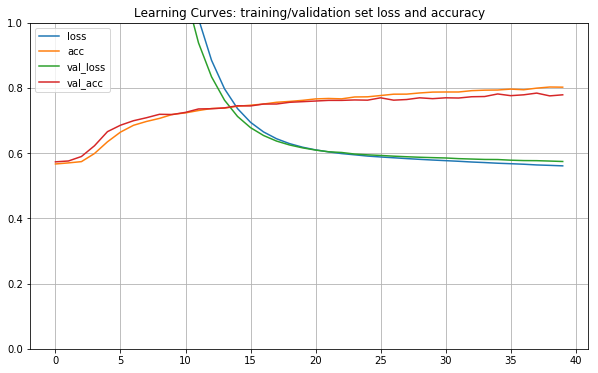

In [116]:
pd.DataFrame(optimized_nn_model.history.history).plot(figsize=(10,6))
plt.grid(True)
plt.title("Learning Curves: training/validation set loss and accuracy")
plt.gca().set_ylim(0,1)
plt.show()

#### 4.5 Using dropout to regularize the 2 layer model

As an alternate method to regularize our overfitted model, below we try to reduce overfitting by the use of *drop out* technique.

In [143]:
n_nuerons = 320

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape = train_array.shape[1:]),
    keras.layers.Dropout(rate=0.25),
    keras.layers.Dense(n_nuerons, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid') #Binary classification and hence sigmoid
])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_9 (Dropout)          (None, 18755)             0         
_________________________________________________________________
dense_1304 (Dense)           (None, 320)               6001920   
_________________________________________________________________
dense_1305 (Dense)           (None, 1)                 321       
Total params: 6,002,241
Trainable params: 6,002,241
Non-trainable params: 0
_________________________________________________________________


In [144]:
#compiling the model
model.compile(loss='binary_crossentropy',
             optimizer=keras.optimizers.SGD(lr=0.01),
             metrics=["accuracy"])

#fitting the model

history = model.fit(train_array,y_train, epochs=40,
                    validation_data=(dev_array, y_dev))


Train on 6090 samples, validate on 1523 samples
Epoch 1/40
6090/6090 [==============================] - 22s 4ms/sample - loss: 0.6871 - acc: 0.5532 - val_loss: 0.6774 - val_acc: 0.5732
Epoch 2/40
6090/6090 [==============================] - 11s 2ms/sample - loss: 0.6743 - acc: 0.5736 - val_loss: 0.6672 - val_acc: 0.5752
Epoch 3/40
6090/6090 [==============================] - 12s 2ms/sample - loss: 0.6656 - acc: 0.5824 - val_loss: 0.6578 - val_acc: 0.5844acc
Epoch 4/40
6090/6090 [==============================] - 12s 2ms/sample - loss: 0.6566 - acc: 0.6015 - val_loss: 0.6474 - val_acc: 0.6211- loss: 0.6578 - a
Epoch 5/40
6090/6090 [==============================] - 12s 2ms/sample - loss: 0.6489 - acc: 0.6195 - val_loss: 0.6371 - val_acc: 0.6533
Epoch 6/40
6090/6090 [==============================] - 12s 2ms/sample - loss: 0.6380 - acc: 0.6527 - val_loss: 0.6258 - val_acc: 0.6783
Epoch 7/40
6090/6090 [==============================] - 12s 2ms/sample - loss: 0.6287 - acc: 0.6672 - val_los

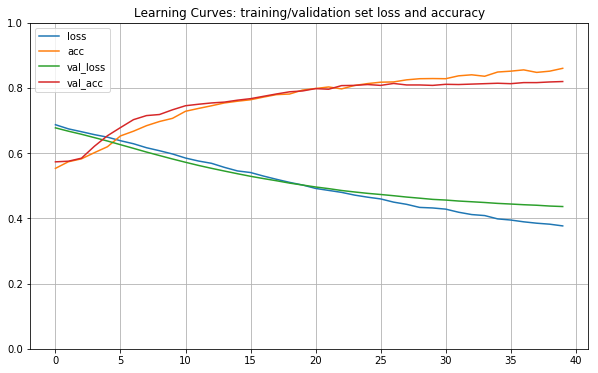

In [145]:
# Plotting the losses and accuracy scores over each epoch 
pd.DataFrame(history.history).plot(figsize=(10,6))
plt.grid(True)
plt.title("Learning Curves: training/validation set loss and accuracy")
plt.gca().set_ylim(0,1)
plt.show()

As expected, the dropout layers significantly reduce the overfitting that we saw in the original model since the accuracy on the training data and the validation data are much closer than the original model with no regularization. But we do not notice a significant increase in the accuracy of model and the performance remains below the best results from the logistic regression model with TFidVectorizer (0.82). 